# Intro to Table Detection with Fast RCNN

By taking an ImageNet-pretrained model such as the VGG16, we can add a few more convolutional layers to construct an RPN, or region proposal network. This module extracts regions of interest, or RoIs, that inform a model on where to identify an object. 


When the RoIs are applied, we do max pooling only in the regions of interest, as to find an embedding that uniquely identifies that area of the input and well as building a description of what object might lie in that region. From this description, the model can then categorize that region into one of k categories it was trained to recognize. 


In [1]:
# Train Fast RCNN

import logging
import pprint
import mxnet as mx
import numpy as np

from rcnn.config import config, default, generate_config
from rcnn.symbol import *
from rcnn.core import callback, metric
from rcnn.core.loader import AnchorLoader
from rcnn.core.module import MutableModule
from rcnn.utils.load_data import load_gt_roidb, merge_roidb, filter_roidb
from rcnn.utils.load_model import load_param


def train_net(args, ctx, pretrained, epoch, prefix, begin_epoch, end_epoch,
              lr=0.001, lr_step='5'):
    # set up logger
    logging.basicConfig()
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    # setup config
    config.TRAIN.BATCH_IMAGES = 1
    config.TRAIN.BATCH_ROIS = 128
    config.TRAIN.END2END = True
    config.TRAIN.BBOX_NORMALIZATION_PRECOMPUTED = True

    # load symbol
    sym = eval('get_' + args.network + '_train')(num_classes=config.NUM_CLASSES, num_anchors=config.NUM_ANCHORS)
    feat_sym = sym.get_internals()['rpn_cls_score_output']


    # setup multi-gpu
    batch_size = len(ctx)
    input_batch_size = config.TRAIN.BATCH_IMAGES * batch_size

    # print config
    pprint.pprint(config)

    # load dataset and prepare imdb for training
    image_sets = [iset for iset in args.image_set.split('+')]
    roidbs = [load_gt_roidb(args.dataset, image_set, args.root_path, args.dataset_path,
                            flip=not args.no_flip)
              for image_set in image_sets]
    roidb = merge_roidb(roidbs)
    roidb = filter_roidb(roidb)

    # load training data
    train_data = AnchorLoader(feat_sym, roidb, batch_size=input_batch_size, shuffle=not args.no_shuffle,
                              ctx=ctx, work_load_list=args.work_load_list,
                              feat_stride=config.RPN_FEAT_STRIDE, anchor_scales=config.ANCHOR_SCALES,
                              anchor_ratios=config.ANCHOR_RATIOS, aspect_grouping=config.TRAIN.ASPECT_GROUPING)

    # infer max shape
    max_data_shape = [('data', (input_batch_size, 3, max([v[0] for v in config.SCALES]), max([v[1] for v in config.SCALES])))]
    max_data_shape, max_label_shape = train_data.infer_shape(max_data_shape)
    max_data_shape.append(('gt_boxes', (input_batch_size, 100, 5)))
    print('providing maximum shape', max_data_shape, max_label_shape)

    # infer shape
    data_shape_dict = dict(train_data.provide_data + train_data.provide_label)
    arg_shape, out_shape, aux_shape = sym.infer_shape(**data_shape_dict)
    arg_shape_dict = dict(zip(sym.list_arguments(), arg_shape))
    out_shape_dict = dict(zip(sym.list_outputs(), out_shape))
    aux_shape_dict = dict(zip(sym.list_auxiliary_states(), aux_shape))
    print('output shape')
    pprint.pprint(out_shape_dict)

    # load and initialize params
    if args.resume:
        arg_params, aux_params = load_param(prefix, begin_epoch, convert=True)
    else:
        arg_params, aux_params = load_param(pretrained, epoch, convert=True)
        arg_params['rpn_conv_3x3_weight'] = mx.random.normal(0, 0.01, shape=arg_shape_dict['rpn_conv_3x3_weight'])
        arg_params['rpn_conv_3x3_bias'] = mx.nd.zeros(shape=arg_shape_dict['rpn_conv_3x3_bias'])
        arg_params['rpn_cls_score_weight'] = mx.random.normal(0, 0.01, shape=arg_shape_dict['rpn_cls_score_weight'])
        arg_params['rpn_cls_score_bias'] = mx.nd.zeros(shape=arg_shape_dict['rpn_cls_score_bias'])
        arg_params['rpn_bbox_pred_weight'] = mx.random.normal(0, 0.01, shape=arg_shape_dict['rpn_bbox_pred_weight'])
        arg_params['rpn_bbox_pred_bias'] = mx.nd.zeros(shape=arg_shape_dict['rpn_bbox_pred_bias'])
        arg_params['cls_score_weight'] = mx.random.normal(0, 0.01, shape=arg_shape_dict['cls_score_weight'])
        arg_params['cls_score_bias'] = mx.nd.zeros(shape=arg_shape_dict['cls_score_bias'])
        arg_params['bbox_pred_weight'] = mx.random.normal(0, 0.001, shape=arg_shape_dict['bbox_pred_weight'])
        arg_params['bbox_pred_bias'] = mx.nd.zeros(shape=arg_shape_dict['bbox_pred_bias'])

    # check parameter shapes
    for k in sym.list_arguments():
        if k in data_shape_dict:
            continue
        assert k in arg_params, k + ' not initialized'
        assert arg_params[k].shape == arg_shape_dict[k], \
            'shape inconsistent for ' + k + ' inferred ' + str(arg_shape_dict[k]) + ' provided ' + str(arg_params[k].shape)
    for k in sym.list_auxiliary_states():
        assert k in aux_params, k + ' not initialized'
        assert aux_params[k].shape == aux_shape_dict[k], \
            'shape inconsistent for ' + k + ' inferred ' + str(aux_shape_dict[k]) + ' provided ' + str(aux_params[k].shape)

    # create solver
    fixed_param_prefix = config.FIXED_PARAMS
    data_names = [k[0] for k in train_data.provide_data]
    label_names = [k[0] for k in train_data.provide_label]
    mod = MutableModule(sym, data_names=data_names, label_names=label_names,
                        logger=logger, context=ctx, work_load_list=args.work_load_list,
                        max_data_shapes=max_data_shape, max_label_shapes=max_label_shape,
                        fixed_param_prefix=fixed_param_prefix)

    # decide training params metric
    rpn_eval_metric = metric.RPNAccMetric()
    rpn_cls_metric = metric.RPNLogLossMetric()
    rpn_bbox_metric = metric.RPNL1LossMetric()
    eval_metric = metric.RCNNAccMetric()
    cls_metric = metric.RCNNLogLossMetric()
    bbox_metric = metric.RCNNL1LossMetric()
    eval_metrics = mx.metric.CompositeEvalMetric()
    for child_metric in [rpn_eval_metric, rpn_cls_metric, rpn_bbox_metric, eval_metric, cls_metric, bbox_metric]:
        eval_metrics.add(child_metric)
        
    # callback
    batch_end_callback = callback.Speedometer(train_data.batch_size, frequent=args.frequent)
    means = np.tile(np.array(config.TRAIN.BBOX_MEANS), config.NUM_CLASSES)
    stds = np.tile(np.array(config.TRAIN.BBOX_STDS), config.NUM_CLASSES)
    epoch_end_callback = callback.do_checkpoint(prefix, means, stds)
    
    # decide learning rate
    base_lr = lr
    lr_factor = 0.1
    lr_epoch = [int(epoch) for epoch in lr_step.split(',')]
    lr_epoch_diff = [epoch - begin_epoch for epoch in lr_epoch if epoch > begin_epoch]
    lr = base_lr * (lr_factor ** (len(lr_epoch) - len(lr_epoch_diff)))
    lr_iters = [int(epoch * len(roidb) / batch_size) for epoch in lr_epoch_diff]
    print('lr', lr, 'lr_epoch_diff', lr_epoch_diff, 'lr_iters', lr_iters)
    lr_scheduler = mx.lr_scheduler.MultiFactorScheduler(lr_iters, lr_factor)
    # optimizer
    optimizer_params = {'momentum': 0.9,
                        'wd': 0.0005,
                        'learning_rate': lr,
                        'lr_scheduler': lr_scheduler,
                        'rescale_grad': (1.0 / batch_size),
                        'clip_gradient': 5}

    # train
    mod.fit(train_data, eval_metric=eval_metrics, epoch_end_callback=epoch_end_callback,
            batch_end_callback=batch_end_callback, kvstore=args.kvstore,
            optimizer='sgd', optimizer_params=optimizer_params,
            arg_params=arg_params, aux_params=aux_params, 
            begin_epoch=begin_epoch, num_epoch=end_epoch)



In [2]:
## Training Args
class DictToObject:
    '''
    helper class to encapsulate all the args from dict to obj
    '''
    def __init__(self, **entries):
        self.__dict__.update(entries)

args = {'lr': 0.001, 'image_set': '2007_trainval', 'network': 'vgg',
        'resume': False, 'pretrained': 'model/vgg16', 'root_path': 'new_data',
        'dataset': 'TableDetectionVOC', 'lr_step': '7', 'prefix': 'model/e2e', 
        'end_epoch': 10, 'dataset_path': 'new_data/VOCdevkit', 
        'gpus': '0',
        'no_flip': False, 'no_shuffle': False, 'begin_epoch': 0, 
        'work_load_list': None, 'pretrained_epoch': 0,
        'kvstore': 'device', 'frequent': 20}

args = DictToObject(**args)
if len(args.gpus) > 1:
    ctx = [mx.gpu(int(i)) for i in args.gpus.split(',')]
else:
    ctx = [mx.gpu(int(args.gpus))]
train_net(args, ctx, args.pretrained, args.pretrained_epoch, args.prefix, args.begin_epoch, args.end_epoch,
              lr=args.lr, lr_step=args.lr_step)


INFO:root:voc_2007_trainval num_images 96
INFO:root:voc_2007_trainval wrote gt roidb to new_data/cache/voc_2007_trainval_gt_roidb.pkl
INFO:root:voc_2007_trainval append flipped images to roidb
INFO:root:load data: filtered 0 roidb entries: 192 -> 192


{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'FIXED_PARAMS': ['conv1', 'conv2'],
 'FIXED_PARAMS_SHARED': ['conv1', 'conv2', 'conv3', 'conv4', 'conv5'],
 'IMAGE_STRIDE': 0,
 'NUM_ANCHORS': 9,
 'NUM_CLASSES': 21,
 'PIXEL_MEANS': array([ 103.939,  116.779,  123.68 ]),
 'RCNN_FEAT_STRIDE': 16,
 'RPN_FEAT_STRIDE': 16,
 'SCALES': [(600, 1000)],
 'TEST': {'BATCH_IMAGES': 1,
          'CXX_PROPOSAL': True,
          'HAS_RPN': False,
          'NMS': 0.3,
          'PROPOSAL_MIN_SIZE': 16,
          'PROPOSAL_NMS_THRESH': 0.7,
          'PROPOSAL_POST_NMS_TOP_N': 2000,
          'PROPOSAL_PRE_NMS_TOP_N': 20000,
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000},
 'TRAIN': {'ASPECT_GROUPING': True,
           'BATCH_IMAGES': 1,
           'BATCH_ROIS': 128,
           'BBOX_MEANS': [0.0, 0.0, 0.0, 0.0],
           'BBOX_NORMALIZATION_PRECOMPUTED': True,
           'BBOX_REGRESSION_THRESH': 0.

('providing maximum shape', [('data', (1, 3, 600, 1000)), ('gt_boxes', (1, 100, 5))], [('label', (1, 20646)), ('bbox_target', (1, 36, 37, 62)), ('bbox_weight', (1, 36, 37, 62))])
output shape
{'bbox_loss_reshape_output': (1L, 128L, 84L),
 'blockgrad0_output': (1L, 128L),
 'cls_prob_reshape_output': (1L, 128L, 21L),
 'rpn_bbox_loss_output': (1L, 36L, 37L, 48L),
 'rpn_cls_prob_output': (1L, 2L, 333L, 48L)}
model/vgg16
vgg16
('lr', 0.001, 'lr_epoch_diff', [7], 'lr_iters', [1344])


INFO:root:Epoch[0] Batch [20]	Speed: 2.15 samples/sec	Train-RPNAcc=0.889323,	RPNLogLoss=0.341211,	RPNL1Loss=2.383475,	RCNNAcc=0.919271,	RCNNLogLoss=0.542955,	RCNNL1Loss=1.662519,	
INFO:root:Epoch[0] Batch [40]	Speed: 1.86 samples/sec	Train-RPNAcc=0.921970,	RPNLogLoss=0.237035,	RPNL1Loss=2.204537,	RCNNAcc=0.946265,	RCNNLogLoss=0.380384,	RCNNL1Loss=1.641250,	
INFO:root:Epoch[0] Batch [60]	Speed: 2.14 samples/sec	Train-RPNAcc=0.931288,	RPNLogLoss=0.217199,	RPNL1Loss=2.083694,	RCNNAcc=0.954918,	RCNNLogLoss=0.319815,	RCNNL1Loss=1.648535,	
INFO:root:Epoch[0] Batch [80]	Speed: 2.14 samples/sec	Train-RPNAcc=0.942708,	RPNLogLoss=0.194358,	RPNL1Loss=1.975555,	RCNNAcc=0.958140,	RCNNLogLoss=0.296030,	RCNNL1Loss=1.662756,	
INFO:root:Epoch[0] Batch [100]	Speed: 2.14 samples/sec	Train-RPNAcc=0.949799,	RPNLogLoss=0.170075,	RPNL1Loss=1.901846,	RCNNAcc=0.958694,	RCNNLogLoss=0.283281,	RCNNL1Loss=1.730938,	
INFO:root:Epoch[0] Batch [120]	Speed: 2.14 samples/sec	Train-RPNAcc=0.953157,	RPNLogLoss=0.158023,	

INFO:root:Epoch[4] Batch [60]	Speed: 2.14 samples/sec	Train-RPNAcc=0.998079,	RPNLogLoss=0.009575,	RPNL1Loss=1.217968,	RCNNAcc=0.963627,	RCNNLogLoss=0.168922,	RCNNL1Loss=1.830536,	
INFO:root:Epoch[4] Batch [80]	Speed: 2.13 samples/sec	Train-RPNAcc=0.998119,	RPNLogLoss=0.008514,	RPNL1Loss=1.159664,	RCNNAcc=0.964024,	RCNNLogLoss=0.165328,	RCNNL1Loss=1.797933,	
INFO:root:Epoch[4] Batch [100]	Speed: 2.14 samples/sec	Train-RPNAcc=0.998221,	RPNLogLoss=0.007840,	RPNL1Loss=1.135140,	RCNNAcc=0.963800,	RCNNLogLoss=0.163978,	RCNNL1Loss=1.775786,	
INFO:root:Epoch[4] Batch [120]	Speed: 2.14 samples/sec	Train-RPNAcc=0.998354,	RPNLogLoss=0.007482,	RPNL1Loss=1.093261,	RCNNAcc=0.961841,	RCNNLogLoss=0.169678,	RCNNL1Loss=1.827718,	
INFO:root:Epoch[4] Batch [140]	Speed: 2.13 samples/sec	Train-RPNAcc=0.998504,	RPNLogLoss=0.006852,	RPNL1Loss=1.071231,	RCNNAcc=0.959220,	RCNNLogLoss=0.179170,	RCNNL1Loss=1.880582,	
INFO:root:Epoch[4] Batch [160]	Speed: 2.13 samples/sec	Train-RPNAcc=0.997647,	RPNLogLoss=0.009956

INFO:root:Epoch[8] Batch [100]	Speed: 2.12 samples/sec	Train-RPNAcc=0.998492,	RPNLogLoss=0.003718,	RPNL1Loss=0.653654,	RCNNAcc=0.949489,	RCNNLogLoss=0.151484,	RCNNL1Loss=1.352796,	
INFO:root:Epoch[8] Batch [120]	Speed: 2.14 samples/sec	Train-RPNAcc=0.998612,	RPNLogLoss=0.003600,	RPNL1Loss=0.657594,	RCNNAcc=0.949445,	RCNNLogLoss=0.152661,	RCNNL1Loss=1.352170,	
INFO:root:Epoch[8] Batch [140]	Speed: 2.13 samples/sec	Train-RPNAcc=0.998726,	RPNLogLoss=0.003409,	RPNL1Loss=0.636074,	RCNNAcc=0.948415,	RCNNLogLoss=0.154673,	RCNNL1Loss=1.359763,	
INFO:root:Epoch[8] Batch [160]	Speed: 2.13 samples/sec	Train-RPNAcc=0.998326,	RPNLogLoss=0.004924,	RPNL1Loss=0.689453,	RCNNAcc=0.948273,	RCNNLogLoss=0.157192,	RCNNL1Loss=1.353484,	
INFO:root:Epoch[8] Batch [180]	Speed: 2.12 samples/sec	Train-RPNAcc=0.997820,	RPNLogLoss=0.006430,	RPNL1Loss=0.693493,	RCNNAcc=0.950190,	RCNNLogLoss=0.151823,	RCNNL1Loss=1.355422,	
INFO:root:Epoch[8] Train-RPNAcc=0.997803
INFO:root:Epoch[8] Train-RPNLogLoss=0.006451
INFO:root

In [3]:
# Fast r-cnn trained on VOC2007 dataset

import os
import cv2
import mxnet as mx
import numpy as np
from rcnn.config import config
from rcnn.symbol import get_vgg_test, get_vgg_rpn_test
from rcnn.io.image import resize, transform
from rcnn.core.tester import Predictor, im_detect, im_proposal, vis_all_detection, draw_all_detection
from rcnn.utils.load_model import load_param
from rcnn.processing.nms import py_nms_wrapper, cpu_nms_wrapper, gpu_nms_wrapper

import urllib2
import tempfile

# 5 classes
CLASSES = ('__background__',
           'mk-1', 'mk-2', 'mk-3', 'mk-65', 'mk-96')
          

config.TEST.HAS_RPN = True
SHORT_SIDE = config.SCALES[0][0]
LONG_SIDE = config.SCALES[0][1]
PIXEL_MEANS = config.PIXEL_MEANS
DATA_NAMES = ['data', 'im_info']
LABEL_NAMES = None
DATA_SHAPES = [('data', (1, 3, LONG_SIDE, SHORT_SIDE)), ('im_info', (1, 3))]
LABEL_SHAPES = None

# visualization
CONF_THRESH = 0.7
NMS_THRESH = 0.3
nms = py_nms_wrapper(NMS_THRESH)


def get_net(symbol, prefix, epoch, ctx):
    arg_params, aux_params = load_param(prefix, epoch, convert=True, ctx=ctx, process=True)

    # infer shape
    data_shape_dict = dict(DATA_SHAPES)
    arg_names, aux_names = symbol.list_arguments(), symbol.list_auxiliary_states()
    arg_shape, _, aux_shape = symbol.infer_shape(**data_shape_dict)
    arg_shape_dict = dict(zip(arg_names, arg_shape))
    aux_shape_dict = dict(zip(aux_names, aux_shape))

    # check shapes
    for k in symbol.list_arguments():
        if k in data_shape_dict or 'label' in k:
            continue
        assert k in arg_params, k + ' not initialized'
        assert arg_params[k].shape == arg_shape_dict[k], \
            'shape inconsistent for ' + k + ' inferred ' + str(arg_shape_dict[k]) + ' provided ' + str(arg_params[k].shape)
    for k in symbol.list_auxiliary_states():
        assert k in aux_params, k + ' not initialized'
        assert aux_params[k].shape == aux_shape_dict[k], \
            'shape inconsistent for ' + k + ' inferred ' + str(aux_shape_dict[k]) + ' provided ' + str(aux_params[k].shape)

    predictor = Predictor(symbol, DATA_NAMES, LABEL_NAMES, context=ctx,
                          provide_data=DATA_SHAPES, provide_label=LABEL_SHAPES,
                          arg_params=arg_params, aux_params=aux_params)
    return predictor


def generate_batch(im):
    """
    preprocess image, return batch
    :param im: cv2.imread returns [height, width, channel] in BGR
    :return:
    data_batch: MXNet input batch
    data_names: names in data_batch
    im_scale: float number
    """
    im_array, im_scale = resize(im, SHORT_SIDE, LONG_SIDE)
    im_array = transform(im_array, PIXEL_MEANS)
    im_info = np.array([[im_array.shape[2], im_array.shape[3], im_scale]], dtype=np.float32)
    data = [mx.nd.array(im_array), mx.nd.array(im_info)]
    data_shapes = [('data', im_array.shape), ('im_info', im_info.shape)]
    data_batch = mx.io.DataBatch(data=data, label=None, provide_data=data_shapes, provide_label=None)
    return data_batch, DATA_NAMES, im_scale


def demo_net(predictor, im, vis=False):
    """
    generate data_batch -> im_detect -> post process
    :param predictor: Predictor
    :param image_name: image name
    :param vis: will save as a new image if not visualized
    :return: None
    """

    data_batch, data_names, im_scale = generate_batch(im)
    scores, boxes, data_dict = im_detect(predictor, data_batch, data_names, im_scale)

    all_boxes = [[] for _ in CLASSES]
    for cls in CLASSES:
        cls_ind = CLASSES.index(cls)
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind, np.newaxis]
        keep = np.where(cls_scores >= CONF_THRESH)[0]
        dets = np.hstack((cls_boxes, cls_scores)).astype(np.float32)[keep, :]
        keep = nms(dets)
        all_boxes[cls_ind] = dets[keep, :]

    boxes_this_image = [[]] + [all_boxes[j] for j in range(1, len(CLASSES))]

    # print results
    print('class ---- [[x1, x2, y1, y2, confidence]]')
    for ind, boxes in enumerate(boxes_this_image):
        if len(boxes) > 0:
            print('---------', CLASSES[ind], '---------')
            print(boxes)

    if vis:
        vis_all_detection(data_dict['data'].asnumpy(), boxes_this_image, CLASSES, im_scale)
    else:
        #result_file = image_name.replace('.', '_result.')
        result_file = "output.jpg"
        print('results saved to %s' % result_file)
        im = draw_all_detection(data_dict['data'].asnumpy(), boxes_this_image, CLASSES, im_scale)
        cv2.imwrite(result_file, im)

        
def get_image_from_url(url, img_file):

    req = urllib2.urlopen(url)
    img_file.write(req.read())
    img_file.flush()
    return img_file.name

## Inference - Lets run some predictions


In [4]:
vis = True
gpu = 0
epoch = 10
prefix = 'e2e'

ctx = mx.gpu(gpu)
symbol = get_vgg_test(num_classes=config.NUM_CLASSES, num_anchors=config.NUM_ANCHORS)
predictor = get_net(symbol, prefix, epoch, ctx)



e2e
e2e


class ---- [[x1, x2, y1, y2, confidence]]


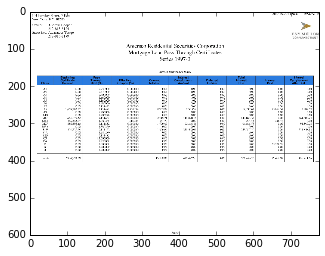

In [8]:
img_file = tempfile.NamedTemporaryFile()
#url = 'http://images.all-free-download.com/images/graphiclarge/aeroplane_boeing_737_air_new_zealand_218019.jpg'
#url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/21.jpg'
#url = 'https://www.siemens.com/press/pool/de/pressebilder/2011/mobility/soimo201107/072dpi/soimo201107-04_072dpi.jpg'
url = '/home/ubuntu/workspace/mxnet/example/rcnn/new_data/VOCdevkit/VOC2007/JPEGImages/Amersco_Residential_Securities_Corporation_Mortgage_Loan_Pass_Through_Certificates_Series_1997_3_2016_10_25_page_003.jpg'

if 'JPEGImages' in url:
    image = url
else:
    image = get_image_from_url(url, img_file)
assert os.path.exists(image), image + ' not found'

im = cv2.imread(image)
demo_net(predictor, im, vis)

## Table Object Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

im = np.array(Image.open('/home/ubuntu/workspace/mxnet/example/rcnn/new_data/marked_table.png'))
plt.imshow(im)
plt.show()